In [1]:
print('Script started...')

Script started...


In [2]:
# Download, preprocess and store data using our own database manager
from database import Database
import os

if not os.path.exists("Database"):
    os.mkdir("Database")
db = Database(os.path.join(os.curdir, "Database"))

all_participants = ["MM05","MM08","MM09","MM10","MM11","MM12","MM14","MM15","MM16","MM18","MM19","MM20","MM21","P02"]
# Warning: One participant is 2-3 GB of data, and ~10 minutes to download, so all of them can take hours
participants_to_load = ["MM05"]

download = True # a quick turn-off switch - so you don't re-process stuff unnecessarily

if download: 
    for participant in participants_to_load:
        db.initialize(participant) # Go and have a coffee, the download takes a while


In [3]:
# Load data from disk
train_on = 'speaking'   # options: thinking, speaking, mixed, concat (some combinations aren't allowed)
test_on = 'speaking'

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = [],[],[],[],[],[]
for participant in participants_to_load:
    tX_train, tX_valid, tX_test, tY_train, tY_valid, tY_test = db.load_data(participant, train_on, test_on, train_size=0.8, test_size=0.1)
    X_train += tX_train
    X_valid += tX_valid
    X_test += tX_test
    Y_train += tY_train
    Y_valid += tY_valid
    Y_test += tY_test

In [4]:
# Data preparation
from tensorflow.keras.utils import to_categorical
import numpy as np

X_train = np.asarray(X_train).transpose((0,2,1))
X_valid = np.asarray(X_valid).transpose((0,2,1))    # Conv1d need the last dimension to be the channels
X_test = np.asarray(X_test).transpose((0,2,1))

yset = set(Y_train + Y_valid + Y_test)
phoneme_to_num = (dict((c,i) for i, c in enumerate(yset)))  # dictionaries to convert back and forth
num_to_phoneme = (dict((i,c) for i, c in enumerate(yset)))
num_of_categories = len(phoneme_to_num)

ylist = []
for item in Y_train:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_train = ylist
ylist = []
for item in Y_valid:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_valid = ylist
ylist = []
for item in Y_test:
    ylist.append(to_categorical(phoneme_to_num[item],num_of_categories)) # one-hot encoding
Y_test = ylist

In [5]:
# Create (or reset) the neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
input_length,channels = X_train[0].shape

model = 0   # to keep my gpu memory from filling up with old nets
model = Sequential()


# model.add(Flatten(input_shape=(input_length, channels)))      # operation overfit
# model.add(Dense(100))
# model.add(Dense(100, activation = 'relu'))
# model.add(Dense(100, activation = 'relu'))
# model.add(Dense(num_of_categories, activation='softmax'))


model.add(Conv1D(filters=256,strides = 10, kernel_size=100, activation='relu', input_shape=(input_length, channels), kernel_initializer = 'he_normal'))
model.add(Conv1D(filters=128,strides = 5, kernel_size=20, activation='relu', kernel_initializer = 'he_normal'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_initializer = 'he_normal'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_initializer = 'he_normal'))
model.add(Flatten())
model.add(Dense(400, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(200, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(100, activation = 'relu', kernel_initializer = 'he_normal'))
model.add(Dense(num_of_categories, activation='softmax', kernel_initializer = 'he_normal'))

#model.add(Dropout(0.25)) # might be worth adding a few in the future

optimizer=Adam(lr=0.1)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.build()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 513, 256)          1587456   
                                                                 
 conv1d_1 (Conv1D)           (None, 99, 128)           655488    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 18, 64)            2

c:\Users\Andras\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
# Callbacks
from keras.callbacks import EarlyStopping

patience = 50
early_stopping = EarlyStopping(patience=patience, verbose=1)

# Szintén a validációs hibát figyeljük, és elmentjük a legjobb modellt
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)


# a tanulálsi ráta (lr, learning rate) automatikus csökkentésére szolgáló függvény
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor= 'val_loss', factor=0.8, patience = 20, min_lr=10e-5)


# a tanulási ráta kézzel írt szabályok alapján történő csökkentésére szolgáló függvény
# ezt most a tanítás során nem fogjuk használni, de érdemes kipróbálni a ReduceLROnPlateau
# függvény helyett

# from keras.callbacks import LearningRateScheduler

# def scheduler(epoch):

#     result = 0.1
#     if epoch>30:
#         result = 0.05
#     if epoch > 60:
#         result = 10e-3
#     if epoch > 90:
#         result = 0.1
#     print("lr = ", result)
#     return result
# change_lr = LearningRateScheduler(scheduler)
# loggolás előkészítése és elnevezése
# from datetime import datetime
# time = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = "logs/" + "XOR_keras" + time
# from keras.callbacks import TensorBoard
# tensorboard_callback = TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

from keras.callbacks import Callback
class TrainingHistory(Callback):
    # Tanulási folyamat elején létrehozunk egy-egy üres listát a kinyerni kívánt metrikák tárolása céljából.
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
    
    # Minden egyes tanítási fázis végén mentsük el, hogy hogyan teljesít aktuálisan a háló. 
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('accuracy'))
        self.valid_accs.append(logs.get('val_accuracy'))
        self.epoch +=1

            
history = TrainingHistory()

In [8]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid) # is this still needed?
Y_valid = np.asarray(Y_valid)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)



model.fit(X_train, Y_train, epochs=5000, batch_size=32, validation_data=(X_valid, Y_valid), verbose=2,callbacks = [
    early_stopping,
    reduce_lr,
    history,
    #tensorboard_callback,
    #change_lr,
    checkpointer
    ], shuffle = True)
    


Epoch 1/5000

Epoch 1: val_loss improved from inf to 4605.42236, saving model to weights.hdf5
5/5 - 21s - loss: 390.4344 - accuracy: 0.0611 - val_loss: 4605.4224 - val_accuracy: 0.0000e+00 - lr: 0.1000 - 21s/epoch - 4s/step
Epoch 2/5000

Epoch 2: val_loss improved from 4605.42236 to 108.85120, saving model to weights.hdf5
5/5 - 1s - loss: 1765.5338 - accuracy: 0.1450 - val_loss: 108.8512 - val_accuracy: 0.0625 - lr: 0.1000 - 822ms/epoch - 164ms/step
Epoch 3/5000

Epoch 3: val_loss improved from 108.85120 to 2.37010, saving model to weights.hdf5
5/5 - 1s - loss: 56.0617 - accuracy: 0.1221 - val_loss: 2.3701 - val_accuracy: 0.1875 - lr: 0.1000 - 847ms/epoch - 169ms/step
Epoch 4/5000

Epoch 4: val_loss did not improve from 2.37010
5/5 - 1s - loss: 3.9483 - accuracy: 0.0992 - val_loss: 2.3777 - val_accuracy: 0.1875 - lr: 0.1000 - 534ms/epoch - 107ms/step
Epoch 5/5000

Epoch 5: val_loss did not improve from 2.37010
5/5 - 1s - loss: 2.4569 - accuracy: 0.0916 - val_loss: 2.3853 - val_accuracy

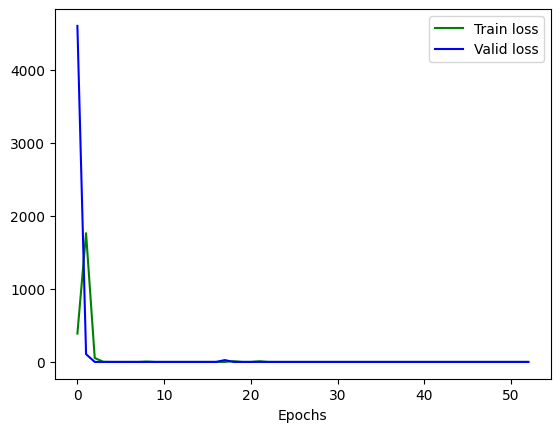

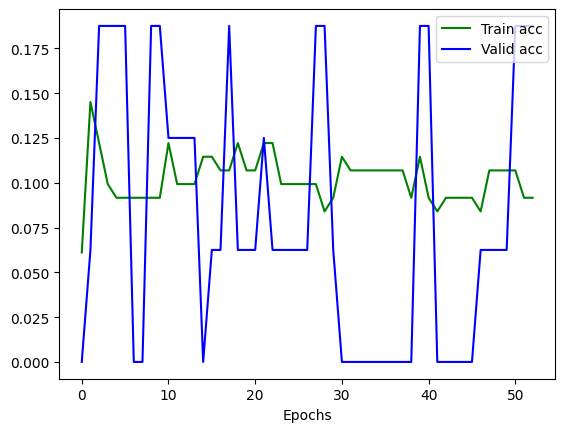

In [9]:
# Plot losses and accuracy over epochs
import matplotlib.pyplot as plt
plt.plot(np.arange(history.epoch), history.losses, color ='g', label='Train loss') 
plt.plot(np.arange(history.epoch), history.valid_losses, color ='b', label='Valid loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()
plt.plot(np.arange(history.epoch), history.accs, color ='g', label='Train acc') 
plt.plot(np.arange(history.epoch), history.valid_accs, color ='b', label='Valid acc')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

In [10]:
# Load best model:
from tensorflow.keras.models import load_model
model = load_model('weights.hdf5')

1/1 [==============================] - 1s 531ms/step


C:\Users\Andras\AppData\Local\Temp\ipykernel_17496\3071776591.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(phoneme_to_num)
C:\Users\Andras\AppData\Local\Temp\ipykernel_17496\3071776591.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(phoneme_to_num)


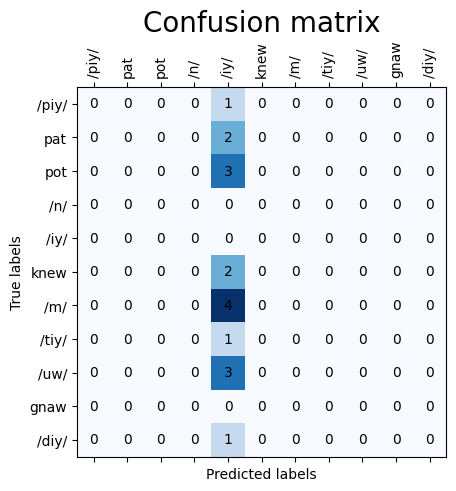

Trained on: speaking,     Tested on: speaking
Test accuracy:  0.0
Precision 0.0
Recall 0.0
f1_score 0.0


c:\Users\Andras\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Andras\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Test accuracy and confusion matrix - and a few more metrics that might come in handy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

preds = np.argmax(model.predict(X_test), axis = 1)
y_true = np.argmax(Y_test,axis=1)

conf = confusion_matrix(y_true, preds,labels = list(num_to_phoneme))

def plotmatrix(title, intersection_matrix):
    it = range(num_of_categories)
    fig, ax = plt.subplots(constrained_layout=True)
    ax.set_title(title, fontdict={'fontsize': 20})

    ax.matshow(intersection_matrix, cmap=plt.cm.Blues)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_xticklabels(phoneme_to_num)
    ax.set_yticklabels(phoneme_to_num)
    plt.xticks(rotation=90)
    ax.set_xticks(it)
    ax.set_yticks(it)

    for i in it:
        for j in it:
            c = intersection_matrix[j, i]
            ax.text(i, j, str(round(c, 2)), va='center', ha='center')

plotmatrix('Confusion matrix',conf)
plt.show()

print('Trained on: ' + train_on + ',     Tested on: '+ test_on)
print('Test accuracy: ', accuracy_score(y_true,preds))
print("Precision", precision_score(y_true, preds, average="macro"))
print("Recall", recall_score(y_true, preds, average="macro"))
print("f1_score", f1_score(y_true, preds, average="macro"))

In [ ]:
# in case we turn it on later
#%load_ext tensorboard
#%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 21224), started 0:21:59 ago. (Use '!kill 21224' to kill it.)